### Generate simulation

1. generate causal design matrix
2. generate simulated expression data across tissues, individuals
3. compute summary stats
4. compare output of individual tissue models, joint tissue models, and summary stat models
    - 

Take as input
- genotype matrix $X$
- percent variance explained of phenotype
- a $T \times N$ causal snp design matrix

Returns
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
from coloc.independent_model import IndependentFactorSER
from coloc.spike_and_slab_ser import SimpleMVNFactorSER
from coloc.spike_and_slab_ser2 import MVNFactorSER

In [5]:
two_tissue = np.array([[1, 0, 1], [0, 1, 1]])
three_tissue = np.array([[1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, 1, 1], [0, 0, 1, 0, 1, 1, 1,]])

In [6]:
genes = np.array(['.'.join(x.split('.')[:-2]) for x in os.listdir('/work-zfs/abattle4/karl/gp_fine_mapping/eQTL_sign/associations/chr22/')])
gene = genes[30]
print('Training model for {}'.format(gene))

# load genotype
print('loading genotype matrix...')
genotype_path = "/work-zfs/abattle4/lab_data/GTEx_v8_trans_eqtl_data_processed_by_brian/processed_genotypes/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_chr22_dosage_MAF_05.txt"
chr22_genotype = pd.read_csv(genotype_path, sep='\t', index_col=0, na_values='-')

Training model for ENSG00000100427.15
loading genotype matrix...


In [7]:
# load associations
print('loading associations...')
associations = pd.read_csv('/work-zfs/abattle4/karl/gp_fine_mapping/eQTL_sign/associations/chr22/{}.associations.txt'.format(gene), sep='\t', header=None)
column_names = ['tissue', 'gene_id', 'variant_id', 'tss_distance','ma_samples', 'ma_count', 'maf', 'pval_nominal', 'slope', 'slope_se']
associations.columns = column_names
tissues = np.unique(associations.tissue)
associations.loc[:, 'z_score'] = associations.slope / associations.slope_se

loading associations...


In [8]:
# figure out tss
tss = int(associations.iloc[0].variant_id.split('_')[1]) - associations.iloc[0].tss_distance

# select variants within 1Mb of tss
pos = chr22_genotype.reset_index().loc[:, 'index'].apply(lambda x: int(x.split('_')[1])).values
in_range = np.logical_and((pos < tss + 1000000), (pos > tss - 1000000))

# filter out variants with missing genotype data
cis_variants = chr22_genotype.loc[in_range]
nan_filter = ~np.any(np.isnan(cis_variants.values), 1)
cis_variants = cis_variants.loc[nan_filter]

In [9]:
def compute_sigma2(X, true_effect, pve):
    var = np.var(true_effect @ X)
    sigma2_t = var/pve - var
    return sigma2_t

def generate_data(X, T, pve, linkage):
    """
    X: genotype data
    T: number of tissues
    pve: variance explained in simulation by X
    
    for multiple tissues we generate independent, normally distirbuted
    effect sizes for each tissue
    
    there are two causal variants approximately (ld)
    """
    N, M = X.shape

    # normalize and compute LD
    X = (X - X.mean(1)[:, None]) / np.sqrt(np.var(X, 1))[:, None]
    LD = X @ X.T / M

    # select snps
    snp1 = np.random.choice(N)
    snp2 = np.argmin(np.abs((np.abs(LD[snp1]) - linkage)))
    causal_snps = np.array([snp1, snp2])

    # generate effect sizes
    true_effects = np.zeros((T, X.shape[0]))
    true_effects[:, causal_snps] = np.random.normal(size=(T, causal_snps.size)) * 0.6
    tissue_variance = np.array([compute_sigma2(X, te, pve) for te in true_effects])

    #simulate expression
    expression = (true_effects @ X) + np.random.normal(size=(T, M)) * np.sqrt(tissue_variance)[:, None]
    expression = expression - expression.mean(1)[:, None]

    # generate summary statistics
    zscores = (expression @ X.T / M) / np.sqrt(tissue_variance[:, None] / M)

    data = {
        'LD': LD,
        'X': X,
        'Y': expression,
        'zscores': zscores,
        'causal_snps': causal_snps,
        'true_effects': true_effects,
        'tissue_variance': tissue_variance
    }
    
    return data

In [184]:
data = generate_data(cis_variants.values[:1000], 20, 0.1, 0.5)

In [192]:
from coloc.independent_model import IndependentFactorSER
from coloc.spike_and_slab_ser import SimpleMVNFactorSER
from coloc.spike_and_slab_ser2 import MVNFactorSER

In [193]:
g = IndependentFactorSER(X=data['X'], Y=data['Y'], K=20)
m = SimpleMVNFactorSER(X=data['LD'], Y=data['zscores'], K=20)
n = MVNFactorSER(X=data['LD'], Y=data['zscores'], K=20)

In [194]:
%%time
g.fit(max_iter=10, update_active=False, update_pi=True, ARD_weights=True, update_variance=True, verbose=True)

Iter 0: -35600.94762605338
Iter 1: -34612.64951127108
Iter 2: -34573.214638964884
Iter 3: -34555.337498478526
Iter 4: -34544.20775378257
Iter 5: -34535.79934664183
Iter 6: -34529.103350454716
Iter 7: -34524.38584858226
Iter 8: -34521.318149734034
Iter 9: -34519.10106049132
cumulative run time: 4.659459352493286
CPU times: user 4.63 s, sys: 11 ms, total: 4.64 s
Wall time: 4.66 s


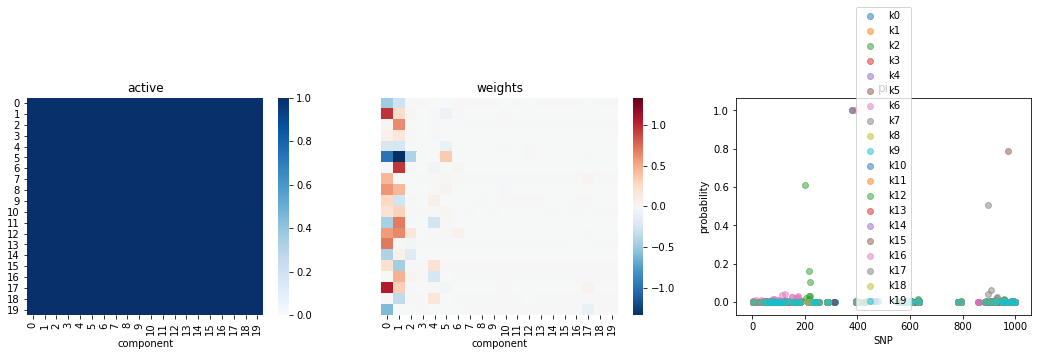

In [195]:
g.plot_components()

In [196]:
%%time
n.fit(max_iter=100, update_active=False, ARD_weights=True, verbose=True)

Iter 0: 388.3395002817543
Iter 1: 639.8286264808587
Iter 2: 672.0377668262201
Iter 3: 698.4719935133317
Iter 4: 711.1028493194398
Iter 5: 717.486068310364
Iter 6: 722.6705884357768
Iter 7: 727.2184095704635
Iter 8: 731.2817903339204
Iter 9: 736.2427676558774
Iter 10: 746.4077761981104
Iter 11: 749.5348766375063
Iter 12: 750.7915612256608
Iter 13: 751.6550835765661
Iter 14: 752.3467375952536
Iter 15: 752.9376756165622
Iter 16: 753.4640646616052
Iter 17: 753.9500181712515
Iter 18: 754.4146933658299
Iter 19: 754.875242594228
Iter 20: 755.3482263403728
Iter 21: 755.8491662629932
Iter 22: 756.3875078762445
Iter 23: 756.9528545169744
Iter 24: 757.5011077527371
Iter 25: 757.980207201011
Iter 26: 758.3854016346796
Iter 27: 758.7479104492518
Iter 28: 759.0821578765668
Iter 29: 759.3766774275209
Iter 30: 759.6272705961863
Iter 31: 759.8535751545426
Iter 32: 760.0761322124031
Iter 33: 760.2990915167655
Iter 34: 760.5114393129747
Iter 35: 760.6998939273735
Iter 36: 760.8604105285465
Iter 37: 760.9

In [198]:
n.fit(max_iter=10, update_active=False, ARD_weights=True, verbose=True)

Iter 0: 765.0199258694606
Iter 1: 765.0359496981341
Iter 2: 765.051554869175
Iter 3: 765.0667666175666
Iter 4: 765.0816046160694
Iter 5: 765.0960858687498
Iter 6: 765.1102258434116
Iter 7: 765.1240389244633
Iter 8: 765.1375386065159
Iter 9: 765.1507375896745
cumulative run time: 42.28372049331665


In [54]:
%%time
m.fit(max_iter=100, update_active=False, ARD_weights=True, verbose=True)

Iter 0: -68.02868577320609
Iter 1: 262.89771875493466
Iter 2: 323.9677727754399
Iter 3: 454.0117852108528
Iter 4: 552.3654580471602
Iter 5: 613.8069721914487
Iter 6: 643.9628292676337
Iter 7: 666.4190430524169
Iter 8: 686.605410998495
Iter 9: 705.7993391971826
Iter 10: 717.8684213204693
Iter 11: 725.9628463875251
Iter 12: 732.9085840883513
Iter 13: 738.9744412036592
Iter 14: 743.2957095120977
Iter 15: 746.5709822162244
Iter 16: 749.3356541593969
Iter 17: 752.015961344156
Iter 18: 755.6750556476461
Iter 19: 760.2281700564503
Iter 20: 763.2237766576728
Iter 21: 765.3472368339781
Iter 22: 767.3221029234356
Iter 23: 769.5361357121078
Iter 24: 771.7324724950513
Iter 25: 773.7784692997361
Iter 26: 775.4886509101997
Iter 27: 776.9062172285975
Iter 28: 778.1600723680101
Iter 29: 779.2949155027951
Iter 30: 780.2967924142451
Iter 31: 781.1382771174801
Iter 32: 781.8278809631119
Iter 33: 782.4103477752159
Iter 34: 782.9319747455762
Iter 35: 783.4134866303365
Iter 36: 783.8483880570069
Iter 37: 78

In [63]:
g.active

array([[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
       [0.99, 0.99, 0.99, 0.99, 0.99, 0.9

In [55]:
np.abs((m.elbos[-1] - m.elbos[-2]) / m.elbos[-2])

2.8274321814036483e-05

In [56]:
np.abs((n.elbos[-1] - n.elbos[-2]) / n.elbos[-2])

6.383306023541085e-05

In [57]:
np.abs((g.elbos[-1] - g.elbos[-2]) / g.elbos[-2])

2.969333542547307e-07

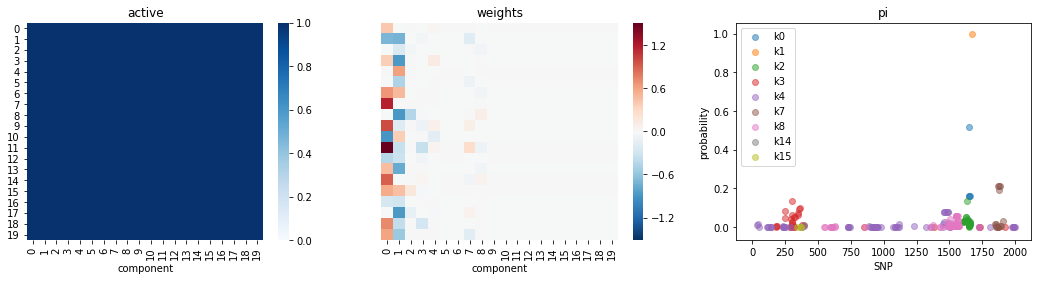

In [58]:
g.plot_components()

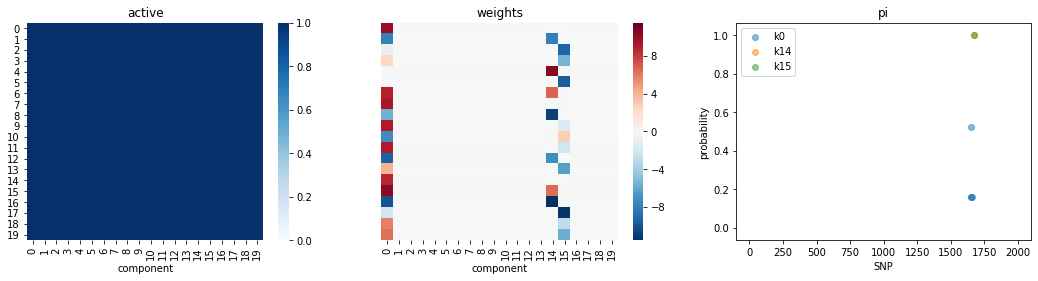

In [59]:
m.plot_components()

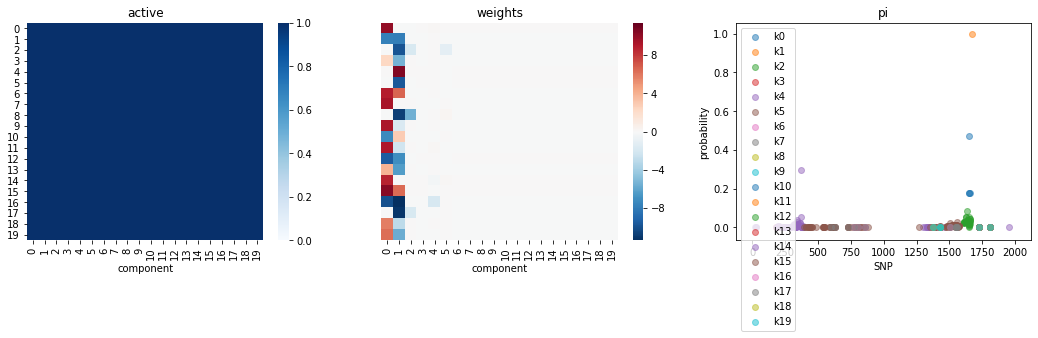

In [60]:
n.plot_components()

In [32]:
%%prun
m.compute_prediction()

In [ ]:
m._compute_prediction()

In [ ]:
.compute_prediction_component()

In [ ]:
%%time
n.compute_prediction()

In [ ]:
plt.plot(np.log(np.log(np.log(n.elbos[1:]))))

In [ ]:
plt.plot((np.array(n.elbos) - np.roll(n.elbos, shift=1))[1:])

In [ ]:
%%time
n._compute_prediction()

In [ ]:
%%time
n._compute_prediction_old()

In [ ]:
n.compute_prediction_component.cache_info()

In [ ]:
g.fit(max_iter=20, update_active=False, update_pi=True, ARD_weights=True, update_variance=True, verbose=True)

In [ ]:
plt.plot(g.elbos)

In [ ]:
data['causal_snps']

In [ ]:
g.get_credible_sets()[0][0], g.get_credible_sets()[0][1]

In [ ]:
g.plot_components()

In [ ]:
from coloc.spike_and_slab_ser2 import MVNFactorSER
m = MVNFactorSER(X=data['LD'], Y=data['zscores'], K=5)
%prun m.fit(max_iter=50, update_active=False, update_pi=True, ARD_weights=False, verbose=True)

In [ ]:
m.plot_components()

In [ ]:
m.get_credible_sets()

In [ ]:
plt.plot(m.elbos)

In [ ]:
from coloc.spike_and_slab_ser2 import MVNFactorSER
m = MVNFactorSER(X=data['LD'], Y=data['zscores'], K=5)

In [ ]:
%prun m.fit(max_iter=5, update_active=False, update_pi=True, update_weights=True, ARD_weights=False, verbose=True)

In [ ]:
from coloc.spike_and_slab_ser2 import MVNFactorSER
m = MVNFactorSER(X=data['LD'], Y=data['zscores'], K=5)

In [ ]:
%prun m.fit(max_iter=5, update_active=False, update_pi=True, update_weights=True, ARD_weights=False, verbose=True)

In [ ]:
plt.plot(m.elbos)

In [ ]:
from coloc.spike_and_slab_ser2 import MVNFactorSER
m = MVNFactorSER(X=data['LD'], Y=data['zscores'], K=10)
m.active = np.ones_like(m.active)
%prun m.fit(max_iter=20, update_active=False, update_pi=True, update_weights=True, ARD_weights=True, verbose=True)

In [ ]:
plt.plot(m.elbos)

In [ ]:
m.plot_components()

In [ ]:
m.get_credible_sets()

In [ ]:
m.weight_means.shape

In [ ]:
C = np.zeros((1000, 1000))
for tissue in range(m.dims['T']):
    for k1 in range(m.dims['K']):
        for k2 in range(m.dims['K']):
            if k1 != k2:
                C += np.outer(m.weight_means[tissue, k1] * m.pi[k1], m.weight_means[tissue, k2] * m.pi[k2])
            else:
                C += np.diag((m.weight_means[tissue, k1]**2 + m.weight_vars[tissue, k1]) * m.pi[k1])
                
result = np.einsum('ij,ij->i', m.X, C).sum()

In [ ]:
%%timeit
np.einsum('ij,ij->i', m.X, C).sum()

In [ ]:
%%timeit
np.trace(m.X@C)

In [ ]:
tissue = 0 
a = m.active[tissue] @ ((m.pi * m.weight_means[tissue]) @ m.X)


In [ ]:
m.active.shape, m.pi.shape, m.weight_means.shape, m.X.shape

In [ ]:
pred = np.zeros_like(m.Y)
for k in range(5):
    active= m.active[:, k]
    pi = m.pi[k]
    weights = m.weight_means[:, k]
    pred += active[:, None] * (pi * weights) @ m.X

In [ ]:
pred

In [ ]:
active[:, None] * (pi * weights) @ m.X

In [ ]:
plt.plot(m.elbos)

In [ ]:
m.plot_components()

In [ ]:
cs, p = g.get_credible_sets()

In [ ]:
g.plot_components()

In [ ]:
m.get_credible_sets()

In [ ]:
data['causal_snps']

In [ ]:
%%time
np.sum([m.weight_means[:, k][:, None] * m.pi[k] @ m.X for k in range(20)], 1)

In [ ]:
%%time
m.weight_means[:, 0][:, None] * m.pi[0] @ m.X

In [ ]:
%%time
m._compute_prediction()

In [ ]:
m.Y.shape

In [ ]:
g.plot_components()

In [ ]:
m.plot_components()

In [ ]:
g.X.shape

In [ ]:
data['causal_snps']

In [ ]:
g.pi.argmax(1)

In [ ]:
cs, p = m.get_credible_sets()

In [ ]:
cs

In [ ]:
plt.scatter(
    data['true_effects'][:, data['causal_snps'][1]],
    g.weight_means[:, 0, data['causal_snps'][1]]
)

In [ ]:
plt.scatter(
    data['true_effects'][:, data['causal_snps'][0]],
    g.weight_means[:, 1, data['causal_snps'][0]]
)

In [ ]:
data['causal_snps']

In [ ]:
g.pi[0].argmax()

In [ ]:
g.weight_means[:, 0, data['causal_snps'][1]]

In [ ]:
data = generate_data(cis_variants.values, 50, 0.2, 0.5)

In [ ]:
from coloc.independent_model import IndependentFactorSER
g = IndependentFactorSER(X=data['X'], Y=data['Y'], K=20)
%prun g.fit(max_iter=5, update_active=False, update_pi=True, ARD_weights=True, update_variance=True, verbose=True)

In [ ]:
g.plot_components()

In [ ]:
tissue = 4
k=0
np.inner((g.weight_vars[tissue, k] + g.weight_means[tissue, k]**2), g.pi[k]) * g.active[tissue, k]

In [ ]:
g.prior_variance.shape

In [ ]:
(g.weight_vars[:, k] + g.weight_means[:, k]**2) @ g.pi[k] * g.active[:, k]

In [ ]:
g.plot_components()

In [ ]:
from coloc.independent_model import IndependentFactorSER
g = IndependentFactorSER(X=data['X'], Y=data['Y'], K=20)
g.active = np.ones_like(g.active)
%prun g.fit(max_iter=5, update_active=False, update_pi=True, ARD_weights=True, update_variance=True, verbose=True)

In [ ]:
g.plot_components()

In [ ]:
data.keys()

In [ ]:
data['true_effects'][:, data['causal_snps']]

In [ ]:
r_k = g.compute_residual(k)
for tissue in range(g.dims['T']):
    if False:
        g.prior_variance[tissue, k] = np.inner(
            (g.weight_vars[tissue, k] + g.weight_means[tissue, k]**2), g.pi[k]) * g.active[tissue, k]

    mask = ~np.isnan(g.Y[tissue])
    diag = np.einsum('ij, ij->i', g.X[:, mask], g.X[:, mask])

    precision = (diag / g.tissue_variance[tissue]) + (1 / g.prior_variance[tissue, k])
    variance = 1 / precision
    mean = (variance / g.tissue_variance[tissue]) * (g.X[:, mask] @ r_k[tissue, mask].T)

In [ ]:
mask = np.isnan(g.Y)
diag = np.array([g._get_diag(t) for t in range(g.dims['T'])])

r_k = g.compute_residual(k)
r_k[mask] = 0

precision = (diag / g.tissue_variance[:, None]) + (1 / g.prior_variance[:, k])[:, None]
variance = 1 / precision
mean = (variance / g.tissue_variance[:, None]) * (r_k @ g.X.T)

In [ ]:
mean

In [ ]:
mean1[1]

In [ ]:
np.allclose(g._compute_prediction(3), g._compute_prediction2(3))

In [ ]:
g._compute_prediction2()

In [ ]:
g.fit(max_iter=5, update_active=False, update_pi=True, ARD_weights=True, update_variance=True, verbose=True)

In [ ]:
g._compute_second_moment.cache_info()

In [ ]:
a = g._compute_prediction()
b = np.array([g.compute_first_moment(k) for k in range(20)]).sum(0)
np.allclose(a, b)

In [ ]:
g.dims

In [ ]:
np.array([g.compute_first_moment(k) for k in range(20)]).sum(0)

In [ ]:
%prun g.compute_residual()

In [ ]:
g._compute_first_moment.cache_info()

In [ ]:
data['causal_snps']

In [ ]:
cs[0], cs[1]

In [ ]:
g._compute_ERSS()

In [ ]:
g.compute_first_moment(0);

In [ ]:
g._compute_first_moment.cache_info()

In [ ]:
from coloc.kls import normal_kl
k=1
r_k = g.compute_residual(k)
pi_k = np.zeros(g.dims['N'])
for tissue in range(g.dims['T']):
    mask = g._get_mask(tissue)
    diag = g._get_diag(tissue)
    tmp1 = (-0.5 / g.tissue_variance[tissue]) * (
        - 2 * r_k[tissue, mask] @ (g.weight_means[tissue, k] * g.X[:, mask].T)
        + g.weight_means[tissue, k] ** 2 * diag
    )
    tmp2 = -0.5 * (1 / g.tissue_variance[tissue]) * (g.weight_vars[tissue, k]) * diag
    tmp3 = -1 * normal_kl(g.weight_means[tissue, k], g.weight_vars[tissue, k], 0.0, g.prior_variance[tissue, k])
    pi_k += (tmp1 + tmp2 + tmp3) * g.active[tissue, k]
pi_k += np.log(g.prior_pi)

# normalize to probabilities
pi_k = np.exp(pi_k - pi_k.max())
pi_k = pi_k / pi_k.sum()

In [ ]:
pi_k.shape

In [ ]:
from scipy.stats import norm

In [ ]:
g.dims

In [ ]:
r_k.shape

In [ ]:
%%timeit
mask = g._get_mask(tissue)
diag = g._get_diag(tissue)
tmp1 = (-0.5 / g.tissue_variance[tissue]) * (
    - 2 * r_k[tissue, mask] @ (g.weight_means[tissue, k] * g.X[:, mask].T)
    + g.weight_means[tissue, k] ** 2 * diag
)

In [ ]:
%%timeit
mask = g._get_mask(tissue)
diag = g._get_diag(tissue)
tmp1b = (-0.5 / g.tissue_variance[tissue]) * (
    - 2 * r_k[tissue, mask] @ (g.X[:, mask].T) * g.weight_means[tissue, k]
    + g.weight_means[tissue, k] ** 2 * diag
)

In [ ]:
g.Y[g.Y > 0] = np.nan

In [ ]:
mask = g._get_mask(0)

In [ ]:
r_k = g.compute_residual(k)

In [ ]:
(r_k[0, mask] @ g.X[:, mask].T)

In [ ]:
r_k[np.isnan(g.Y)] = 0
r_k @ g.X.T

In [ ]:
from coloc.kls import normal_kl
k=0
mask = g._get_mask(k)
diag = np.array([g._get_diag(t) for t in range(g.dims['T'])])

In [ ]:
%%time
r_k = g.compute_residual(k)
r_k[np.isnan(g.Y)] = 0
tmp1c = (-0.5 / g.tissue_variance[:, None]) * (
    - 2 * r_k @ (g.X.T) * g.weight_means[:, k]
    + g.weight_means[:, k] ** 2 * diag
)
tmp2c = -0.5 * (1 / g.tissue_variance[:, None]) * (g.weight_vars[:, k]) * diag
tmp3c = -1 * normal_kl(g.weight_means[:, k], g.weight_vars[:, k], 0.0, g.prior_variance[:, k][:, None])
pi_k = (tmp1c + tmp2c + tmp3c) * g.active[:, k][:, None]

pi_k = pi_k.sum(0)
pi_k += np.log(g.prior_pi)
pi_k = np.exp(pi_k - pi_k.max())
pi_k = pi_k / pi_k.sum()

In [ ]:
%%time
r_k = g.compute_residual(k)
r_k[np.isnan(g.Y)] = 0
pi_k2 = np.zeros((g.dims['N']))
for tissue in range(g.dims['T']):
    mask = g._get_mask(tissue)
    diag = g._get_diag(tissue)
    tmp1 = (-0.5 / g.tissue_variance[tissue]) * (
        - 2 * r_k[tissue, mask] @ (g.weight_means[tissue, k] * g.X[:, mask].T)
        + g.weight_means[tissue, k] ** 2 * diag
    )
    tmp2 = -0.5 * (1 / g.tissue_variance[tissue]) * (g.weight_vars[tissue, k]) * diag
    tmp3 = -1 * normal_kl(g.weight_means[tissue, k], g.weight_vars[tissue, k], 0.0, g.prior_variance[tissue, k])
    pi_k2 += (tmp1 + tmp2 + tmp3) * g.active[tissue, k]

pi_k2 += np.log(g.prior_pi)
pi_k2 = np.exp(pi_k2 - pi_k2.max())
pi_k2 = pi_k2 / pi_k2.sum()

In [ ]:
diag

In [ ]:
np.allclose(pi_k, pi_k2)

In [ ]:
pi_k.sum(0)
pi_k += np.log(g.prior_pi)
pi_k = np.exp(pi_k - pi_k.max())
pi_k = pi_k / pi_k.sum()

In [ ]:
pi_k

In [ ]:
g._update_active_component(k)
g.pi[k]

In [ ]:
tmp1c[tissue]


In [ ]:
tmp1

In [ ]:
tmp1b

In [ ]:
((g.weight_means[:, k][..., None] * g.X[None]) @ r_k.T).shape

In [ ]:
norm.logpdf(r_k).shape

In [ ]:
%%prun
residual = g.ge(0)

In [ ]:
mu2 = (g.pi[component]
       * (g.weight_means[tissue, component]**2 + g.weight_vars[tissue, component])
       * g.active[tissue, component]) @ (g.X[:, mask]**2)


In [ ]:
mu = (g.pi[component]
      * g.weight_means[:, component]
      * g.active[:, component][:, None]) @ g.X[:, mask]

In [ ]:
g.compute_prediction(0)

In [ ]:
g.compute_moments(0)

In [ ]:
np.allclose(mu, np.array([g.compute_first_moment(t, component) for t in range(50)]))

In [ ]:
g._compute_prediction_component_cache.cache_info()

In [ ]:
np.allclose(ERSSs, g._compute_ERSS())

In [ ]:
g.plot_components()

In [ ]:
cs, p = g.get_credible_sets()

In [ ]:
data['causal_snps']

In [ ]:
p

In [ ]:
cs

In [ ]:
g.plot_credible_sets_ld()

In [ ]:
[(g._update_weight_component(k), g._update_pi_component(k)) for k in range(20)]

In [ ]:
def var(a, b):
    return np.sum(b - a**2)

In [ ]:
g._update_tissue_variance()
g.tissue_variance

In [ ]:
%%time
g._compute_ERSS() / g.Y.shape[1]

In [ ]:
g.compute_elbo()

In [ ]:
residual = g.compute_residual()

In [ ]:
np.sum([[g.compute_moments(t, k)[0]**2 for t in range(10)] for k in range(10)])

In [ ]:
%%prun
((g.pi[None] * g.weight_means[:, :] * g.active[:, :, None] @ g.X)**2).sum()

In [ ]:
(g.compute_prediction(use_covariates=)[~np.isnan(g.Y)]**2).sum()

In [ ]:
g._compute_covariate_prediction()

In [ ]:
g._update_tissue_variance()
g.tissue_variance

In [ ]:
g.X.shape

In [ ]:
%%prun
g.fit(max_iter=10, update_active=False, update_variance=False, verbose=True)

In [ ]:
plt.plot(g.elbos[1:])

In [ ]:
g.plot_components()

In [ ]:
cs, p = m.get_credible_sets()

In [ ]:
data.keys()

In [ ]:
g.get_expected_weights()[:, :2]

In [ ]:
plt.scatter(
    g.weight_means[:, [0, 1], data['causal_snps']],
    data['true_effects'][:, data['causal_snps']]
)

plt.scatter(
    g.get_expected_weights()[:, :2],
    data['true_effects'][:, data['causal_snps']]
)

In [ ]:
cs[0], cs[1], cs[2]

In [ ]:
p

In [ ]:
g._get_diag.cache_info()

In [ ]:
g._compute_first_moment.cache_info()

In [ ]:
g._compute_second_moment.cache_info()

In [ ]:
g.dims

In [ ]:
%%prun
mu, mu2 = g._compute_moments(1, 0)
print(g._compute_second_moment.cache_info())

In [ ]:
%%time
g._compute_prediction()

In [ ]:
tuple(a for a in range(10))

In [ ]:
%%timeit
mu, mu2 = g._compute_moments(2, 2)

In [ ]:
_compute_first_moment.cache_info()

In [ ]:
%%prun
mu, mu2 = g._compute_moments(1, 1)

In [ ]:
%%prun
g._compute_prediction()

In [ ]:
from coloc.independent_model import _compute_first_moment

In [ ]:
_compute_first_moment.cache_info()

In [ ]:
%%time
a = g.X.tobytes()

In [ ]:
g._compute_first_moment.cache_info()

In [ ]:
%%time
mu, mu2 = g._compute_moments(1, 0)

In [ ]:
%%timeit
mu, mu2 = g._compute_moments(1, 0)

In [ ]:
%%time
mu, mu2 = g._compute_moments(0, 1)

In [ ]:
%%prun
g.fit(max_iter=10, verbose=True, update_active=False, ARD_weights=False, update_variance=True)

In [ ]:
g._compute_first_moment.cache_info()

In [ ]:
from coloc.utils import array_to_hashable, hashable_to_array

In [ ]:
a = np.random.random((10, 10))
b = np.random.random((50, 2))
c = np.random.random((12))

In [ ]:
d, e, f = hashable_to_array(array_to_hasable(a, b, c))

In [ ]:
np.all(d == a), np.all(e == b), np.all(f == c)

In [ ]:
%%time
g._compute_prediction()

In [ ]:
np.array([g._compute_first_moment(0, k) for k in range(4)])

In [ ]:
from functools import lru_cache, wraps
import numpy as np

def np_cache(*args, **kwargs):
    """
    LRU cache implementation for functions whose FIRST parameter is a numpy array
    """
    def decorator(function):
        @wraps(function)
        def wrapper(np_array, *args, **kwargs):
            hashable_array = array_to_tuple(np_array)
            return cached_wrapper(hashable_array, *args, **kwargs)

        @lru_cache(*args, **kwargs)
        def cached_wrapper(hashable_array, *args, **kwargs):
            array = np.array(hashable_array)
            return function(array, *args, **kwargs)

        def array_to_tuple(np_array):
            """Iterates recursivelly."""
            try:
                return tuple(array_to_tuple(_) for _ in np_array)
            except TypeError:
                return np_array

        # copy lru_cache attributes over too
        wrapper.cache_info = cached_wrapper.cache_info
        wrapper.cache_clear = cached_wrapper.cache_clear
        return wrapper
    return decorator

In [ ]:
def pack(*args):
    """
    take a list of numpy arrays, pack them into a single array
    return single flat numpy array
    return list of shape tuples for unpacking
    """
    
    flat = np.concatenate([x.flatten() for x in args])
    
    size = [0]
    size.extend([x.size for x in args])
    size = list(np.cumsum(size))
    
    shapes = [x.shape for x in args]
    
    return flat, size, shapes

def unpack(flat, size, shape):
    return (flat[size[i]:size[i+1]].reshape(shape[i]) for i in range(len(shape)))

In [ ]:
a = np.random.random((10, 3))
b = np.random.random(5)
c = np.array(1.0)
d = np.random.random((3, 6))
flat, size, shape = pack(a, b, c, d)

In [ ]:
a1, b1, c1, d1 = unpack(flat, size, shape)

In [ ]:
a1 == a

In [ ]:
b1 == b

In [ ]:
c1 == c

In [ ]:
g.active[0, 0].shape

In [ ]:
shape

In [ ]:
from time import sleep

@np_cache()
def test_func(a):
    sleep(1.0)

In [ ]:
%%time
test_func(np.zeros(4))

In [ ]:
g = IndependentFactorSER(X=data['X'], Y=data['Y'], K=4)
s = MVNFactorSER(X=data['LD'], Y=['zscores'], K=4)
ss = SimpleMVNFactorSER(X=data['LD'], Y=['zscores'], K=4)

In [ ]:
g.prior_activity = np.ones_like(g.prior_activity) * 0.9

In [ ]:
%%time
g.fit(max_iter=100, verbose=True, update_active=True, ARD_weights=False, update_variance=False)

In [ ]:
%%prun
g.fit(max_iter=50, update_variance=False, update_active=False, verbose=True)

In [ ]:
hash(g.weight_means.tostring())

In [ ]:
g._compute_first_moment.cache_info()

In [ ]:
g._compute_moments(0, 0)[0].shape

In [ ]:
%%prun
g.compute_elbo()

In [ ]:
%%prun
mu, mu2 = g._compute_moments(0, 0)

In [ ]:
g.dims

In [ ]:
data['tissue_variance'], g.tissue_variance

In [ ]:
a = g.pi[0, cs[0]]
a

In [ ]:
b = g.weight_means[0, 0, cs[0]]
b

In [ ]:
np.inner(a, b)

In [ ]:
data['true_effects'][:, data['causal_snps']], g.get_expected_weights()

In [ ]:
g.get_credible_sets()

In [ ]:
data = {
    'LD': LD,
    'X': X,
    'Y': expression,
    'zscores': slopes/std_errs,
    'causal_snps': causal_snps,
    'true_effects': true_effects
}

In [ ]:
plt.scatter(np.arange(N), true_effects[2])

In [ ]:
plt.scatter(np.arange(N), (slopes/std_errs)[1])
plt.scatter(np.arange(N)[causal_snps], (slopes/std_errs)[1, causal_snps])

In [ ]:
stats.norm.cdf(-np.abs(slopes/std_errs)) * 2

In [ ]:
p_values

In [ ]:
true_effects = np.zeros(N)
true_effects[causal_snps[0]] = np.abs(np.random.normal(size=1) * 0.6)

v = np.var(true_effects @ X)
sigma2 = v/0.01 - v

In [ ]:
X.shape

In [ ]:
true_effects.shape

In [ ]:
x = X[causal_snps[0]]
y = (true_effects @ X) + np.random.normal(size=M) * np.sqrt(sigma2)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_value**2


In [ ]:
r_values**2

In [ ]:
(r_values**2).mean()

In [ ]:
plt.hist((r_values**2).flatten(), bins=100);

In [ ]:
X = (X - X.mean(1)[:, None]) / np.sqrt(np.var(X, 1))[:, None]

In [ ]:
(X @ X.T) / 838

In [ ]:
N

In [ ]:
LD

In [ ]:
X @ X.T

In [ ]:
# load expression
print('loading expression...')
expression = pickle.load(open('./chr22_expression', 'rb'))
expression = pd.concat(expression, sort=True)
expression.reset_index(inplace=True)
expression.rename(columns={'level_0': 'tissue'}, inplace=True)
expression.set_index(['gene_id', 'tissue'], inplace=True)

In [ ]:
associations

In [ ]:
 associations.variant_id.apply(lambda x: int(x.split('_')[1])) - associations.tss_distance

In [ ]:
associations.variant_id.apply(lambda x: x.split('_')[1])

In [ ]:
import panda_plink

In [ ]:
associations

In [ ]:
chr22_genotype